In [ ]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [70]:
# Load the image
image_path = "Test Images/image1.jpeg"
image = cv2.imread(image_path)

# Crop the image
x = 675
y = 300
w = 2500
h = 2400
cropped_image = image[y : y + h, x : x + w]

# Resize the image
resize_image = cv2.resize(cropped_image, (720, 720))

# Convert the image to HSV
hsv_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2HSV)

In [71]:
# Define the lower and upper bounds of the HSV range
h_min = 13
h_max = 25
s_min = 52
s_max = 111
v_min = 75
v_max = 209

# Create masks based on the HSV range
def create_mask(hsv_image):
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

mask = create_mask(hsv_image)

In [72]:
# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
countour_image = cv2.drawContours(resize_image.copy(), contours, -1, (0, 255, 0), 5)

In [73]:
# Filter contours based on area
contours_area_image = resize_image.copy()
min_area = 10000
selected_contours = []

for c in contours:
    area = cv2.contourArea(c)
    if min_area <= area:
        selected_contours.append(c)

contours = selected_contours.copy()
selected_contours.remove(max(selected_contours, key=cv2.contourArea))

In [74]:
A1, A2, A3 = None, None, None

# Assign the areas to the corresponding variables
for c in selected_contours:
    x, y, w, h = cv2.boundingRect(c)
    x_mid = x + w // 2
    y_mid = y + h // 2
    if (x_mid < 360) and (y_mid < 360):
        print("Top left")
        A1 = ["A1", c, cv2.contourArea(c), (x_mid, y_mid)]
    elif (x_mid > 360) and (y_mid < 360):
        print("Top right")
        A2 = ["A2", c, cv2.contourArea(c), (x_mid, y_mid)]
    else:
        print("Bottom")
        A3 = ["A3", c, cv2.contourArea(c), (x_mid, y_mid)]
    # cv2.circle(contours_area_image, (x_mid, y_mid), 10, (0, 255, 0), -1)
    # cv2.rectangle(contours_area_image, (x, y), (x + w, y + h), (0, 255, 0), 10)

required_contours = [A1, A2, A3]
for sc in required_contours:
    if sc is None:
        continue
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(contours_area_image, [sc[1]], -1, color, 5)
    cv2.putText(contours_area_image, sc[0], sc[3], cv2.FONT_HERSHEY_SIMPLEX, 3, color, 5)

Bottom
Top left
Top right


In [75]:
boxes_image = resize_image.copy()
rectContours = contours.copy()
newImage = resize_image.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(boxes_image, (x, y), (x + w, y + h), (0, 255, 0), 5)
    
max_contour = max(rectContours, key=lambda c: cv2.contourArea(c))
A0 = cv2.boundingRect(max_contour)

rectContours.remove(max(rectContours, key=cv2.contourArea))

for c in rectContours:
    rect = cv2.boundingRect(c)
    x_mid = rect[0] + rect[2] // 2
    y_mid = rect[1] + rect[3] // 2
    if (x_mid < 360) and (y_mid < 360):
        print("Top left")
        A1 = ["A1", c, rect]
    elif (x_mid > 360) and (y_mid < 360):
        print("Top right")
        A2 = ["A2", c, rect]
    else:
        print("Bottom")
        A3 = ["A3", c, rect]

cv2.line(
    newImage, (A0[0] + A0[2], A0[1]), (A0[0] + A0[2], A0[1] + A0[3]), (0, 255, 0), 5
)  # h1

cv2.line(
    newImage,
    (int(A0[0]), A3[2][1]),
    (int(A0[0]), A0[1]),
    (0, 255, 0),
    5,
)  # h2


cv2.line(
    newImage,
    (int(A3[2][0] + A3[2][2] / 2), A3[2][1] + A3[2][3]),
    (int(A3[2][0] + A3[2][2] / 2), A0[1] + A0[3]),
    (0, 255, 0),
    5,
) # B1

cv2.line(
    newImage,
    (int(A1[2][0] + A1[2][2] / 2), A1[2][1]),
    (int(A1[2][0] + A1[2][2] / 2), A0[1]),
    (0, 255, 0),
    5,
)  # B2

cv2.line(
    newImage,
    (int(A2[2][0] + A2[2][2] / 2), A2[2][1]),
    (int(A2[2][0] + A2[2][2] / 2), A0[1]),
    (0, 255, 0),
    5,
)  # B3

Bottom
Top left
Top right


array([[[ 66,  69,  75],
        [ 56,  59,  65],
        [ 94,  97, 102],
        ...,
        [109, 110, 118],
        [ 77,  79,  87],
        [ 15,  17,  25]],

       [[ 89,  92,  97],
        [ 81,  84,  89],
        [ 61,  64,  69],
        ...,
        [112, 114, 122],
        [ 55,  57,  65],
        [ 18,  20,  28]],

       [[134, 137, 142],
        [127, 130, 135],
        [104, 107, 112],
        ...,
        [ 35,  37,  45],
        [ 78,  80,  88],
        [ 75,  77,  85]],

       ...,

       [[102, 109, 118],
        [ 87,  94, 103],
        [ 62,  69,  78],
        ...,
        [ 71,  77,  86],
        [ 75,  81,  90],
        [ 76,  83,  92]],

       [[ 87,  94, 103],
        [114, 121, 130],
        [104, 111, 120],
        ...,
        [ 71,  78,  87],
        [ 74,  81,  90],
        [ 80,  87,  96]],

       [[107, 114, 123],
        [132, 139, 148],
        [193, 199, 208],
        ...,
        [ 69,  76,  85],
        [ 74,  81,  90],
        [ 78,  85,  94]]

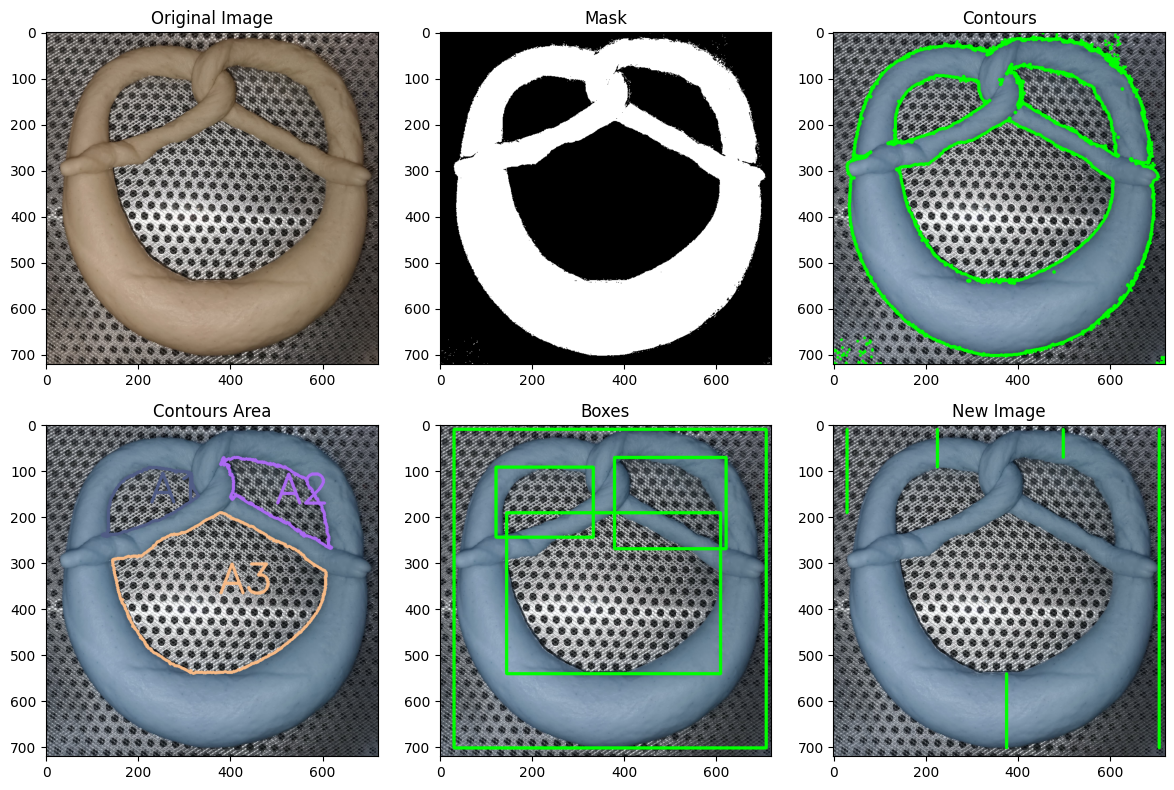

In [76]:
# Increase figure size
plt.figure(figsize=(12, 8))  # Adjust the figsize to fit your needs

row = 2
col = 3

# Adjust subplot parameters to give more space
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Subplot 1
plt.subplot(row, col, 1)
plt.title("Original Image")
plt.imshow(
    cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB)
)  # Convert BGR to RGB for displaying

# Subplot 2
plt.subplot(row, col, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")

# Subplot 3
plt.subplot(row, col, 3)
plt.title("Contours")
plt.imshow(countour_image, cmap="gray")

# Subplot 4
plt.subplot(row, col, 4)
plt.title("Contours Area")
plt.imshow(contours_area_image, cmap="gray")

# Subplot 5
plt.subplot(row, col, 5)
plt.title("Boxes")
plt.imshow(boxes_image, cmap="gray")

# Subplot 6
plt.subplot(row, col, 6)
plt.title("New Image")
plt.imshow(newImage, cmap="gray")

# Adjust layout to ensure there's no overlap
plt.tight_layout()

plt.show()